Loading
---

In this notebook, we will load all and process all necessary data to estimate historical carbon emissions.

First, we import all necessary libraries (these can be installed from the `pyproject.toml` file):

# 1. Preliminaries

In [ ]:
import os
from pathlib import Path

import ee
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from carbon_capture.emissions import calculate_emissions
from mpl_chord_diagram import chord_diagram

First, we initialize our Google EarthEngine project. The project's name is defined in the environment variable `EARTHENGINE_PROJECT`:

In [87]:
ee.Initialize(project=os.environ["EARTHENGINE_PROJECT"])

We define our input and output directories:

In [88]:
input_dir = Path("./data/input/")
output_dir = Path("./data/output/")

# 2. Bounds

As a first step, we load the bounds for our region of interest; for this example, we will work with **Coronel Portillo**, a city in Peru.

<Axes: >

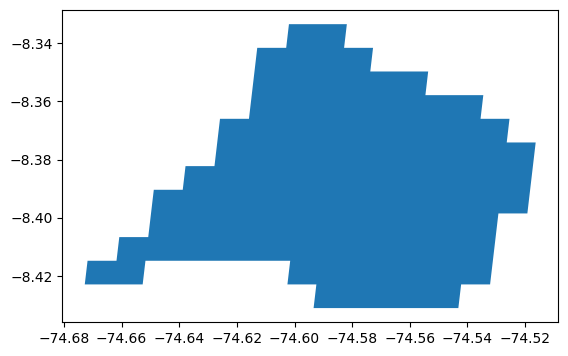

In [89]:
df_bounds = gpd.read_file(input_dir / "bounds.gpkg").to_crs("EPSG:4326")
df_bounds.plot()

We reproject these bounds to a suitable UTM CRS:

In [90]:
crs_utm = df_bounds.estimate_utm_crs()

df_bounds = df_bounds.to_crs(crs_utm)

We apply a buffer of **10 km** to these bounds, and reproject it back to `EPSG:4326`:

<Axes: >

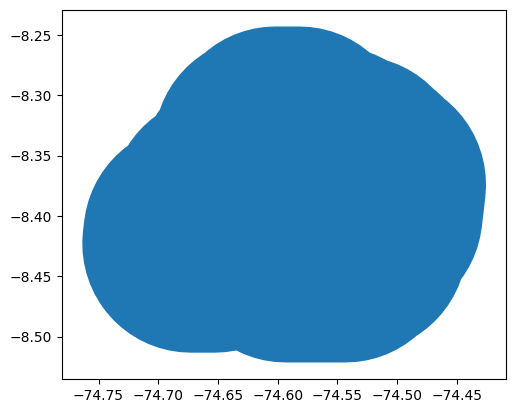

In [91]:
df_bounds = df_bounds.assign(geometry=lambda df: df["geometry"].buffer(10_000)).to_crs(
    "EPSG:4326",
)
df_bounds.plot()

Finally, we extract the geometry:

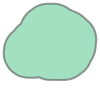

In [92]:
bounds = df_bounds["geometry"].item()
bounds

We then convert these bounds to an EarthEngine `Polygon`:

In [93]:
bounds_ee = ee.geometry.Geometry.Polygon(list(bounds.exterior.coords))

We will use these buffered bounds as our area of interest.

# 3. Class masks

## 3.1 Land use

We use [`GLC_FCS30D`](https://gee-community-catalog.org/projects/glc_fcs/), as our land use dataset. It contains worldwide yearly observations from 2000 to 2022, classifying each $30\times 30$ pixel in one of **35** land cover categories:

In [94]:
glc_img = (
    ee.imagecollection.ImageCollection(
        "projects/sat-io/open-datasets/GLC-FCS30D/annual",
    )
    .filterBounds(bounds_ee)
    .mode()  # Reduce collection to single image
    .clip(bounds_ee)  # Clip to our region
)

The AFOLU model only considers **11** land cover classes:

* Croplands
* Flooded
* Mangroves
* Grasslands
* Pastures
* Other
* Settlements
* Shrublands
* Wetlands
* Primary forests
* Secondary forests

We define a mapping between the 35 GLC_FS30D categories and these eleven classes. Since each GLC class is represented as an integer, for convenience we define said mapping in the following form:

```
class = [
    [start_1, end_1], 
    [start_2, end_2], 
    ...
]
```

Each pair of numbers defines the start and end of an integer range; all GLC IDs within this range (inclusive on both sides) belong to `class`. 

So, for example, our `wetlands` class is defined as follows:

```
wetlands = [
    [181, 184],
    [186, 187]
]
```

This means that `wetlands` includes the following GLC classes:

* 181: Swamp
* 182: Marsh
* 183: Flooded flat
* 184: Saline
* 186: Salt marsh
* 187: Tidal flat

In [95]:
id_map = {
    "croplands": [[10, 20]],
    "flooded": [[210, 210]],
    "forests": [[51, 92]],
    "forests_mangroves": [[185, 185]],
    "grasslands_initial": [[140, 140]],
    "grasslands_to_pastures": [[130, 130]],
    "other": [[150, 153], [200, 202], [50, 50], [220, 220]],
    "settlements": [[190, 190]],
    "shrublands": [[120, 122]],
    "wetlands": [[181, 184], [186, 187]],
}

Comparing with our list of 11 AFOLU classes, one may notice several inconsistencies: we don't distinguish between primary and secondary forests, we don't have a `pasture` or `grasslands` class, and we introduce two previously not mentioned classes: `grasslands_initial` and `grasslands_to_pastures`. These will all be explained in the following sections. 

For now, we map the pixels of our GLC_FS30D image to these new classes:

In [96]:
class_masks = {}
for label, ranges in id_map.items():
    mask = (
        ee.image.Image.constant([0] * 23)
        .rename([f"b{i}" for i in range(1, 24)])
        .clip(bounds_ee)
    )
    for label_range in ranges:
        if label_range[0] == label_range[1]:
            temp_mask = glc_img.eq(label_range[0])
        else:
            temp_mask = glc_img.gte(label_range[0]).And(glc_img.lte(label_range[1]))
        mask = mask.Or(temp_mask)
    class_masks[label] = mask

The result of this is a dictionary where each key corresponds to a different land use class, and each value is a binary image: all of the `True` pixels belong to the land use class.

## 3.2 Forests

It is necessary to distinguish between *primary* and secondary *forests*, since the amount of carbon they capture and store is different. However, this is not possible to do using only the GLC_FS30D dataset. We complement it using the [`Global 2020 Forest Classification for IPCC Aboveground Biomass`](https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_global_forest_classification_2020_V1) dataset, which classifies each $30\times 30$ pixel in one of three categories:

1. Primary forest
2. Young secondary forest
3. Old secondary forest

To determine whether a pixel is a primary or secondary forest, we use the following algorithm:
1. If a pixel is tagged as `forest` in the **class mask** image:
    1. If it's tagged as `primary forest` in the **forest classification** image, we assign it to the `primary_forest` class.
    2. Else, we assign it to the `secondary_forest` class.

Therefore, the first step is to convert the forest classification image into a binary mask:

In [97]:
forest_primary_mask = (
    ee.imagecollection.ImageCollection(
        "NASA/ORNL/global_forest_classification_2020/V1",
    )
    .filterBounds(bounds_ee)
    .mode()
    .clip(bounds_ee)
    .unmask(0)
    .eq(1)  # We are only interested on whether a pixel is tagged as primary or not.
)

Then, we simply `And` it with our `forest` class mask:

In [98]:
class_masks["forests_primary"] = class_masks["forests"].And(
    forest_primary_mask,
)
class_masks["forests_secondary"] = class_masks["forests"].And(
    forest_primary_mask.Not(),  # Notice the `Not`
)

We no longer have a use for our `forest` class mask, so we remove it from the dictionary:

In [99]:
del class_masks["forests"]

## 3.3 Grasslands and pastures

Going back to our `id_map` variable, we recall the two newly introduced classes: `grasslands_initial` and `grasslands_to_pastures`. Both of these map to a single GLC class:

* `grasslands_initial`: GLC class `140` (lichens and mosses)
* `grasslands_to_pastures`: GLC class `130` (also named grasslands)

GLC_FS30D doesn't distinguish between "standard" grasslands, and grasslands used for cattle grazing. Since we need the latter category to model some complementary carbon emissions, we artificially create a `pastures` mask by sampling **40%** of the pixels assigned to the `grasslands_to_pastures` category (i.e., the GLC *grasslands* class). The remaining **60%** gets assigned to the **AFOLU** grasslands class, alongside the entirety of the `grasslands_initial` class.

Perhaps an easier way of visualizing this is with the following "system of equations"

$$
\begin{align}
    \text{Pastures}_\text{AFOLU} &= 0.4 \times \text{Grasslands}_\text{GLC}\\
    \text{Grasslands}_\text{AFOLU} &= (0.6 \times \text{Grasslands}_\text{GLC}) + \text{Lichens and mosses}_\text{GLC}
\end{align}
$$

To actually do this, the first step is to create a random binary mask, where (on average) 40% of the pixels have a `True` value, and 60% a `False` one. We must make sure this mask has the same scale and projection of our class mask image:

In [100]:
proj = glc_img.projection().getInfo()

pastures_random_mask = (
    ee.image.Image.random(42)  # Uniform distribution between 0 and 1
    .reproject(crs=proj["crs"], crsTransform=proj["transform"])
    .lte(0.4)  # 40% of pixels will be True
    .clip(bounds_ee)
)

Then, we `And` this mask with our `grasslands_to_pastures` image to obtain our final `pastures` mask:

In [101]:
class_masks["pastures"] = class_masks["grasslands_to_pastures"].And(
    pastures_random_mask,
)

We also `And` it with the complement, to obtain the remaining 60% that will stay a grassland. Finally, we `Or` this result with our `grasslands_initial` image to obtain our final `grasslands` mask:

In [102]:
class_masks["grasslands"] = (
    class_masks["grasslands_to_pastures"]
    .And(pastures_random_mask.Not())
    .Or(class_masks["grasslands_initial"])
)

We can now delete the `grasslands_initial` and `grasslands_to_pastures` masks:

In [103]:
del class_masks["grasslands_initial"], class_masks["grasslands_to_pastures"]

With this, we have our required 11 class masks:

In [104]:
class_masks

{'croplands': <ee.image.Image at 0x1f4de48d290>,
 'flooded': <ee.image.Image at 0x1f4de48f490>,
 'forests_mangroves': <ee.image.Image at 0x1f4de4a0ad0>,
 'other': <ee.image.Image at 0x1f4de4a2ed0>,
 'settlements': <ee.image.Image at 0x1f4de4a3850>,
 'shrublands': <ee.image.Image at 0x1f4de4a4250>,
 'wetlands': <ee.image.Image at 0x1f4de4a5050>,
 'forests_primary': <ee.image.Image at 0x1f4dc483d90>,
 'forests_secondary': <ee.image.Image at 0x1f4de48b150>,
 'pastures': <ee.image.Image at 0x1f4de48c810>,
 'grasslands': <ee.image.Image at 0x1f4de47dc10>}

# 4. Area table

With our land use images properly defined, the first result we seek to obtain is how much area each class covers, for each year. To optimize the calculation, we meld all of our class masks into a single image: each of the pixels of this image will have an integer value between `1` and `11` (inclusive), indicating the land use class it belongs to. The correspondence between index and class is as follows:

1. Croplands
2. Flooded
3. Mangroves
4. Primary forests
5. Secondary forests
6. Grasslands
7. Other
8. Pastures
9. Settlements
10. Shrublands
11. Wetlands

In [105]:
label_list = [
    "croplands",
    "flooded",
    "forests_mangroves",
    "forests_primary",
    "forests_secondary",
    "grasslands",
    "other",
    "pastures",
    "settlements",
    "shrublands",
    "wetlands",
]

Each band of our class masks corresponds to a different year, starting with band `b1` for the year 2000, and ending with band `b23` for the year 2022. While it is theoretically possible to reduce all bands in a single operation, due to computational limitations of the Earth Engine API, it's more convenient to create a separate image from each band, and reduce them sequentially:

In [106]:
areas = []

for year_idx in range(1, 24):
    band_name = f"b{year_idx}"
    img = ee.image.Image.constant(0).rename("class").uint8()

    for i, label in enumerate(label_list):
        img = img.where(class_masks[label].select(band_name).rename("class"), i + 1)

    img: ee.image.Image = img.addBands(ee.image.Image.pixelArea()).select(
        ["area", "class"],
    )

    response = img.reduceRegion(
        reducer=(ee.reducer.Reducer.sum().group(groupField=1, groupName="transition")),
        scale=30,
        geometry=bounds_ee,
        maxPixels=int(1e10),
    ).getInfo()

    if response is None:
        err = "No response from Earth Engine"
        raise ValueError(err)

    rows = [
        {
            "label": label_list[elem["transition"] - 1],
            "area": float(elem["sum"]),
            "year": year_idx - 1,
        }
        for elem in response["groups"]
        if elem["transition"] != 0
    ]
    areas.extend(rows)

We turn the result into a DataFrame, and convert the area to hectares:

In [107]:
df_area = (
    pd.DataFrame(areas)
    .pivot_table(index="label", columns="year", values="area")
    .divide(10_000)
)
df_area.head(5)

year,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
label,,,,,,,,,,,,,,,,,,,,,
croplands,393.302772,397.549539,386.526968,400.933462,311.089063,299.853268,312.605983,309.802417,305.879492,318.043782,...,428.111693,414.526246,426.224068,471.672148,484.888695,461.096957,457.984102,500.034387,615.857905,607.155238
flooded,4024.475757,4471.992015,3959.540564,4004.107832,3618.411031,3474.503548,3378.249808,3449.837716,4124.535759,4538.414235,...,5113.374386,5177.858211,4969.576058,5298.445228,5532.908946,5731.766592,5199.487313,5039.748438,4902.534620,4950.303994
forests_primary,8183.449491,7932.275945,8340.389537,7830.183659,7703.315081,7528.834276,7244.854083,7562.034654,7381.870874,7206.863420,...,6918.556314,6980.510642,6717.176875,6693.615047,6500.153029,6612.065965,6752.037167,6860.439797,6874.831580,7242.308853
forests_secondary,50907.897069,50727.406112,50406.609554,50504.869843,50819.806690,48613.674383,46321.478010,45446.948753,45575.449851,44813.277862,...,41371.517105,41457.188319,42124.713175,40191.254453,40425.008941,38213.802314,37997.305903,38072.356532,38123.525029,39281.298794
grasslands,2.565548,2.072604,1.238509,2.295617,4.246290,1.415482,1.946301,0.353880,1.061585,1.061632,...,7.342606,7.077185,5.307782,8.492682,10.440128,24.153058,20.701404,20.082122,17.339319,21.320445


For the emissions model to run properly, all land use classes must be present in the table. If any is missing, we add a very small dummy value:

In [108]:
for label in label_list:
    if label not in df_area.index:
        df_area.loc[label] = 0.01
df_area = df_area.sort_index()

# 5. Transition table

The next important result is how much of land use class `A` turned into class `B` between two consecutive years, for all possible class combinations (i.e., `grasslands -> pastures`, `grasslands -> settlements`, `grasslands -> wetlands`, etc.)

First, we list said combinations, and define a unique integer index for each one:

In [109]:
multiplier = 10 ** np.ceil(np.log10(len(label_list)))

transition_map = {}

for i, start_label in enumerate(label_list):
    for j, end_label in enumerate(label_list):
        key = int(i * multiplier + j)
        transition_map[key] = (start_label, end_label)

transition_map_inv = {value: key for key, value in transition_map.items()}

Then, we iterate over each consecutive pair of images and create a new image with all transitions labelled following this map, and calculate the area covered by each label:

In [110]:
all_transitions = []

for year_idx in range(1, 23):
    start_band = f"b{year_idx}"
    end_band = f"b{year_idx + 1}"

    transition_img = ee.image.Image.constant(0).rename("class").uint8().clip(bounds_ee)

    for start_label, start_img in class_masks.items():
        for end_label, end_img in class_masks.items():
            a: ee.image.Image = start_img.select(start_band).rename("class")
            b: ee.image.Image = end_img.select(end_band).rename("class")

            transition_img = transition_img.where(
                a.And(b),
                transition_map_inv[(start_label, end_label)],
            )

    transition_img = transition_img.addBands(
        ee.image.Image.pixelArea(),
    ).select(
        ["area", "class"],
    )

    response = transition_img.reduceRegion(
        reducer=(ee.reducer.Reducer.sum().group(groupField=1, groupName="transition")),
        scale=30,
        geometry=bounds_ee,
        maxPixels=int(1e10),
    ).getInfo()

    rows = [
        {
            "label": transition_map[elem["transition"]],
            "area": float(elem["sum"]),
        }
        for elem in response["groups"]
    ]

    df_transitions = (
        pd.DataFrame(rows)
        .assign(
            start=lambda df: df["label"].str[0],
            end=lambda df: df["label"].str[1],
        )
        .drop(columns=["label"])
        .pivot_table(index="start", columns="end", values="area")
        .fillna(0)
    )

    for label in label_list:
        if label not in df_transitions.index:
            df_transitions.loc[label] = 0.0

        if label not in df_transitions.columns:
            df_transitions[label] = 0.0

    df_transitions = df_transitions.sort_index().sort_index(axis=1)

    all_transitions.append(df_transitions)

The result of this is a list of 22 DataFrames, each with 11 rows and 11 columns. 

* The first DataFrame corresponds to the transitions between 2000 and 2001, the second between 2001 and 2002, etc.
* Each row represents the starting land use class, and each column the final one. The value at cell $(i, j)$ is the total area (in square meters) that converted from $i$ to $j$.

In [111]:
all_transitions[0]

end,croplands,flooded,forests_mangroves,forests_primary,forests_secondary,grasslands,other,pastures,settlements,shrublands,wetlands
start,,,,,,,,,,,
croplands,3.826864e+06,0.000000e+00,0.0,0.000000e+00,8.581591e+04,0.000000,0.000000,1.415461e+04,8.846692e+02,0.000000e+00,5.308325e+03
flooded,0.000000e+00,3.609229e+07,0.0,0.000000e+00,1.740840e+05,0.000000,8847.084534,1.415665e+04,9.731537e+03,8.847125e+03,3.936804e+06
forests_mangroves,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
forests_primary,0.000000e+00,8.847811e+02,0.0,7.511389e+07,0.000000e+00,0.000000,61923.772949,8.846913e+02,8.848025e+02,0.000000e+00,6.656029e+06
forests_secondary,1.238596e+05,9.962544e+05,0.0,0.000000e+00,4.647188e+08,0.000000,165510.429533,1.460882e+06,3.328123e+06,1.512723e+05,3.813424e+07
grasslands,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3538.637817,884.656616,2.654005e+03,1.857818e+04,0.000000e+00,0.000000e+00
other,0.000000e+00,1.681097e+04,0.0,0.000000e+00,1.052765e+05,6570.978721,683110.229152,2.477194e+04,2.149766e+05,1.415540e+04,3.173527e+05
pastures,1.503894e+04,0.000000e+00,0.0,0.000000e+00,1.232335e+06,3538.847351,13269.627380,2.145697e+07,2.264707e+06,1.043861e+05,3.980970e+04
settlements,5.308315e+03,1.769368e+04,0.0,0.000000e+00,2.290364e+06,6192.995850,7077.578247,1.403949e+06,4.233854e+07,7.519410e+04,1.043912e+05


We have to make an important adjustment to ensure the emissions model works properly: there can't be any transitions *into* the primary forests class, only *out* of it. We make anything that turned into a primary forest into a secondary forest instead:

In [112]:
for i, table in enumerate(all_transitions):
    for start in label_list:
        if start == "forests_primary":
            continue

        table.loc[start, "forests_secondary"] = np.nansum(
            [
                table.loc[start, "forests_secondary"],
                table.loc[start, "forests_primary"],
            ],
        )
        table.loc[start, "forests_primary"] = np.nan

    all_transitions[i] = table.fillna(0)

The resultant DataFrame looks as follows:

In [113]:
all_transitions[0]

end,croplands,flooded,forests_mangroves,forests_primary,forests_secondary,grasslands,other,pastures,settlements,shrublands,wetlands
start,,,,,,,,,,,
croplands,3.826864e+06,0.000000e+00,0.0,0.000000e+00,8.581591e+04,0.000000,0.000000,1.415461e+04,8.846692e+02,0.000000e+00,5.308325e+03
flooded,0.000000e+00,3.609229e+07,0.0,0.000000e+00,1.740840e+05,0.000000,8847.084534,1.415665e+04,9.731537e+03,8.847125e+03,3.936804e+06
forests_mangroves,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
forests_primary,0.000000e+00,8.847811e+02,0.0,7.511389e+07,0.000000e+00,0.000000,61923.772949,8.846913e+02,8.848025e+02,0.000000e+00,6.656029e+06
forests_secondary,1.238596e+05,9.962544e+05,0.0,0.000000e+00,4.647188e+08,0.000000,165510.429533,1.460882e+06,3.328123e+06,1.512723e+05,3.813424e+07
grasslands,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3538.637817,884.656616,2.654005e+03,1.857818e+04,0.000000e+00,0.000000e+00
other,0.000000e+00,1.681097e+04,0.0,0.000000e+00,1.052765e+05,6570.978721,683110.229152,2.477194e+04,2.149766e+05,1.415540e+04,3.173527e+05
pastures,1.503894e+04,0.000000e+00,0.0,0.000000e+00,1.232335e+06,3538.847351,13269.627380,2.145697e+07,2.264707e+06,1.043861e+05,3.980970e+04
settlements,5.308315e+03,1.769368e+04,0.0,0.000000e+00,2.290364e+06,6192.995850,7077.578247,1.403949e+06,4.233854e+07,7.519410e+04,1.043912e+05


Comparing with our previous result, we see that the `wetlands -> forests_primary` value is now zero, while the `wetlands -> forests_secondary` increased by this amount.

We turn this matrix into a stochastic matrix by dividing each column by its sum. Now, the value at $(i, j)$ will tell us the *fraction* of total area $i$ that turned into area $j$. If a column sums to zero (which means the corresponding class wasn't present in the region of interest), we set its diagonal to one (an empty transition).

In [114]:
all_transitions_frac = []

for table in all_transitions:
    zero_rows = table.index[table.sum(axis=1) == 0]
    for elem in zero_rows:
        table.loc[elem, elem] = 1

    all_transitions_frac.append(table.divide(table.sum(axis=1), axis=0))

all_transitions_frac[0]

end,croplands,flooded,forests_mangroves,forests_primary,forests_secondary,grasslands,other,pastures,settlements,shrublands,wetlands
start,,,,,,,,,,,
croplands,0.973007,0.000000,0.0,0.000000,0.021819,0.000000,0.000000,0.003599,0.000225,0.000000,0.001350
flooded,0.000000,0.896820,0.0,0.000000,0.004326,0.000000,0.000220,0.000352,0.000242,0.000220,0.097822
forests_mangroves,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
forests_primary,0.000000,0.000011,0.0,0.917876,0.000000,0.000000,0.000757,0.000011,0.000011,0.000000,0.081335
forests_secondary,0.000243,0.001957,0.0,0.000000,0.912862,0.000000,0.000325,0.002870,0.006538,0.000297,0.074908
grasslands,0.000000,0.000000,0.0,0.000000,0.000000,0.137929,0.034482,0.103448,0.724141,0.000000,0.000000
other,0.000000,0.012155,0.0,0.000000,0.076120,0.004751,0.493925,0.017911,0.155439,0.010235,0.229463
pastures,0.000598,0.000000,0.0,0.000000,0.049038,0.000141,0.000528,0.853837,0.090119,0.004154,0.001584
settlements,0.000115,0.000383,0.0,0.000000,0.049523,0.000134,0.000153,0.030356,0.915453,0.001626,0.002257


Finally, we flatten and concatenate all DataFrames into a single one, renaming the columns to make them fit with what the emissions model expects:

In [115]:
rows = []
for i, table in enumerate(all_transitions_frac):
    for start_label in label_list:
        for end_label in label_list:
            rows.append(
                {
                    "transition": f"pij_lndu_{start_label}_to_{end_label}",
                    "time_period": i,
                    "value": table.loc[start_label, end_label],
                },
            )

df_transition_cube = pd.DataFrame(rows).pivot_table(
    index="time_period", columns="transition", values="value",
)
df_transition_cube.head(5)

transition,pij_lndu_croplands_to_croplands,pij_lndu_croplands_to_flooded,pij_lndu_croplands_to_forests_mangroves,pij_lndu_croplands_to_forests_primary,pij_lndu_croplands_to_forests_secondary,pij_lndu_croplands_to_grasslands,pij_lndu_croplands_to_other,pij_lndu_croplands_to_pastures,pij_lndu_croplands_to_settlements,pij_lndu_croplands_to_shrublands,...,pij_lndu_wetlands_to_flooded,pij_lndu_wetlands_to_forests_mangroves,pij_lndu_wetlands_to_forests_primary,pij_lndu_wetlands_to_forests_secondary,pij_lndu_wetlands_to_grasslands,pij_lndu_wetlands_to_other,pij_lndu_wetlands_to_pastures,pij_lndu_wetlands_to_settlements,pij_lndu_wetlands_to_shrublands,pij_lndu_wetlands_to_wetlands
time_period,,,,,,,,,,,,,,,,,,,,,
0,0.973007,0.000000,0.0,0.0,0.021819,0.0,0.0,0.003599,0.000225,0.000000,...,0.042566,0.0,0.0,0.239073,0.000005,0.002072,0.000402,0.000570,0.000878,0.714410
1,0.920562,0.000000,0.0,0.0,0.074765,0.0,0.0,0.001780,0.000668,0.000000,...,0.033521,0.0,0.0,0.246226,0.000000,0.002056,0.000140,0.000635,0.000853,0.716523
2,0.925153,0.000000,0.0,0.0,0.065921,0.0,0.0,0.004578,0.002060,0.000000,...,0.039316,0.0,0.0,0.246263,0.000015,0.002504,0.000582,0.000757,0.000871,0.709640
3,0.691419,0.000000,0.0,0.0,0.292032,0.0,0.0,0.012136,0.001765,0.000221,...,0.040459,0.0,0.0,0.254771,0.000058,0.002776,0.000889,0.000791,0.003455,0.696767
4,0.871460,0.000284,0.0,0.0,0.120008,0.0,0.0,0.005403,0.000284,0.000284,...,0.031200,0.0,0.0,0.174746,0.000000,0.001773,0.000306,0.000464,0.001412,0.790049


# 6. Emissions

We have everything we need to run the emissions model. The relevant functions can be seen in the source file `carbon_capture/emissions.py`, which depends on [SISEPUEDE's repository](https://github.com/jcsyme/sisepuede):

In [117]:
df_emissions = calculate_emissions(
    df_area.reset_index(),
    df_transition_cube.reset_index(),
    iso="PER" # 3-letter ISO code of Peru
)

c:\Users\lain\Documents\carbon_capture\.venv\Lib\site-packages\sisepuede\utilities\_toolbox.py:533: UserWarning: Path 'C:\Users\lain\Documents\carbon_capture\.venv\Lib\site-packages\sisepuede\out\sisepuede_run_2025-08-08T20;13;52.795069' not found. It will not be created.
  warnings.warn(msg)
c:\Users\lain\Documents\carbon_capture\.venv\Lib\site-packages\sisepuede\core\model_attributes.py:6826: UserWarning: 

                        MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution 
                        implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() 
                        to ensure that transition probability rows are enforced on a simplex.
                        
                        
                        FIX THIS ASAP TO DERIVE PROPERLY.
                        
                        
  warnings.warn(
c:\Users\lain\Documents\carbon_capture\.venv\Lib\site-packages\sisepuede\core\model_attributes.py:6826: UserWarning: 

         

# 7. Plots

## 7.1 Area

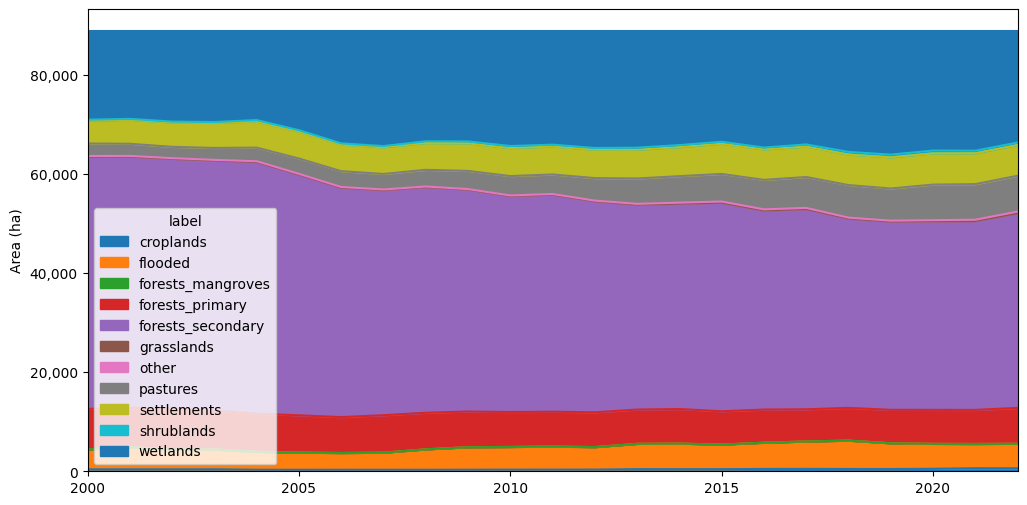

In [137]:
df_plot = (
    df_area
    .transpose()
    .reset_index()
    .assign(year=lambda df: (df["year"] + 2000).astype(int).astype(str))
    .set_index("year")
)

fig, ax = plt.subplots(figsize=(12, 6))
df_plot.plot.area(ax=ax)
ax.set_xlim(0, 22)
ax.set_xlabel("")
ax.set_ylabel("Area (ha)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

## 7.2 Emissions

We can plot the different carbon emission and capture pathways for the region of interest:

Text(0, 0.5, 'CO2 emitted (millions of tons)')

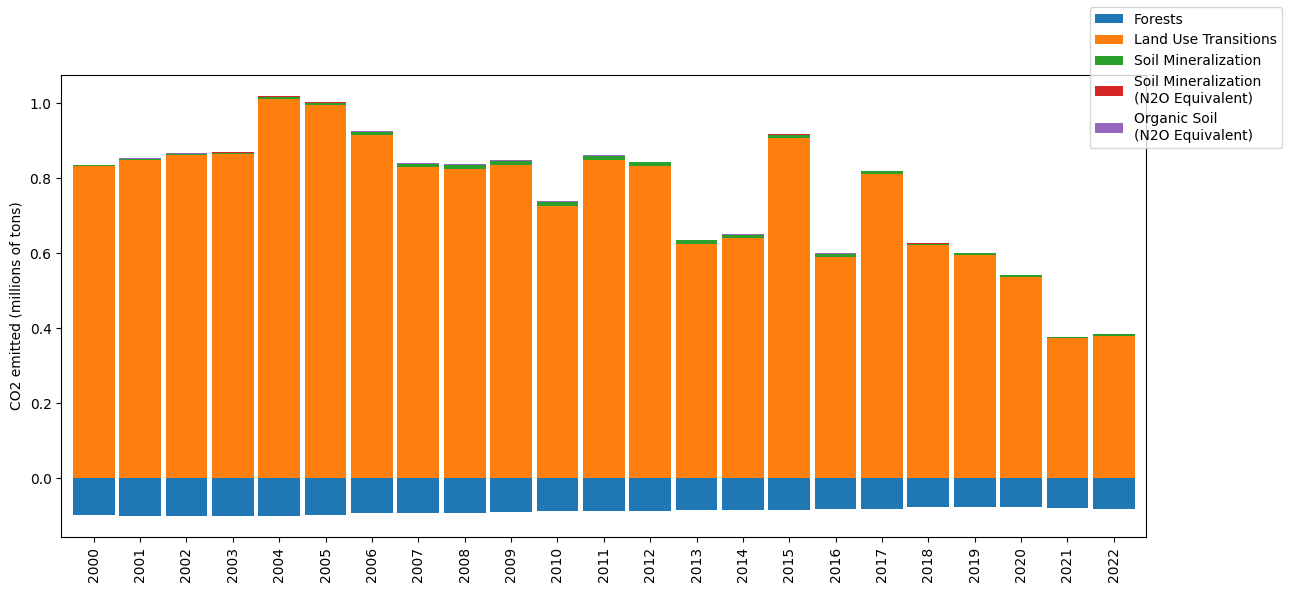

In [119]:
name_map = {
    "emission_co2e_subsector_total_frst": "Forests",
    "emission_co2e_subsector_total_lndu": "Land Use Transitions",
    "emission_co2e_co2_soil_soc_mineral_soils": "Soil Mineralization",
    "emission_co2e_n2o_soil_mineral_soils": "Soil Mineralization\n(N2O Equivalent)",
    "emission_co2e_n2o_soil_organic_soils": "Organic Soil\n(N2O Equivalent)",
}

df_plot = (
    df_emissions
    .reset_index()
    .filter([*list(name_map.keys()), "time_period"], axis="columns")
    .rename(columns=name_map)
    .assign(time_period=lambda df: (df["time_period"] + 2000))
    .query("time_period <= 2022")
    .set_index("time_period")
)

fig, ax = plt.subplots(figsize=(14, 6))
df_plot.plot.bar(stacked=True, ax=ax, width=0.9, legend=False)
fig.legend()
ax.set_xlabel("")
ax.set_ylabel("CO2 emitted (millions of tons)")